In [5]:
import time
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

In [32]:
STEPS = 100
RANGE = 250
N_PERSONAS = 100
LONG_CELDA_EN_M = 0.4
CELDAS_DE_DISTANCIA = 5
PROBABILIDAD_CONTAGIO_CON_MEDIDAS = 0.15
PROBABILIDAD_INICIA_CONTAGIADO = 0.5
N_CONTAGIOS = True

In [21]:
class Persona:
    q_persona = 0
    
    def __init__(self, x_init, y_init, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        self.numero = Persona.q_persona
        Persona.q_persona += 1
        self.tablero = tablero
        self.contagiado = contagiado
        self.steps_enfermo = 0
        self.puede_moverse = puede_moverse
        self.x = x_init
        self.y = y_init
        self.verbose = verbose
        self.α = α
        self.β = β
        self.n_contagios = n_contagios
        
        
    def get_position(self):
        return self.x, self.y
    
    def esta_contagiado(self):
        return self.contagiado
        
    def step(self):
        if self.puede_moverse:
            return self.step_normal()
        else:
            return self.x, self.y
    
    def propagar_contagios(self, n_step):
        if self.contagiado:
            self.steps_enfermo += 1
            if self.steps_enfermo >= self.α:
                if (np.random.rand() <= β):
                    self.contagiado = False
                    self.steps_enfermo = 0
        elif self.n_contagios | (self.steps_enfermo == 0):
            self.contagiado = self.tablero.propagar_contagios_por_cercania(self.x,
                                            self.y, CELDAS_DE_DISTANCIA, n_step)
        
class Tablero:
    """
        α: tiempo de recuperacion
        B: probabilidad de sanar después del tiempo de recuperacion
    """
    def __init__(self, n_dim, n_personas, tasa_contagio_inicial, λ, α, β, n_contagios, T=False, verbose=False):
        self.verbose = verbose
        self.dim = n_dim
        self.personas = self.__init_personas(n_personas, n_contagios, λ, α, β)
        self.tasa_contagio = tasa_contagio_inicial
        self.T = T
        self.personas_contagiadas = []
    
    def __init_personas(self, n_personas, n_contagios, λ, α, β):
        def get_init_positions(n_persons):
            indexes = [(i, j) for i in range(0, self.dim) for j in range(0, self.dim)]
            random.shuffle(indexes)
            return indexes[:n_persons]
        
        def generate_persons(pos, n_contagios, λ, α, β):
            persons = []
            n = np.random.rand(len(pos))
            s = np.random.rand(len(pos))
            m = np.random.rand(len(pos))
            for (x_init, y_init), ni, si, mi in zip(pos, n, s, m):
                contagiado = (si <= PROBABILIDAD_INICIA_CONTAGIADO)
                puede_moverse = (mi <= λ)
                if ni <= 0.1:
                    persons.append(PersonaC(x_init, y_init, self, contagiado, puede_moverse,
                                            α, β, n_contagios, self.verbose))
                elif ni > 0.1 and ni <= 0.3:
                    persons.append(PersonaB(x_init, y_init, self, contagiado, puede_moverse,
                                            α, β, n_contagios, self.verbose))
                else:
                    persons.append(PersonaA(x_init, y_init, self, contagiado, puede_moverse,
                                            α, β, n_contagios, self.verbose))
            return persons
        
        init_positions = get_init_positions(n_personas)
        return generate_persons(init_positions, n_contagios, λ, α, β)
        
    def get_movimientos_posibles(self, x, y):
        movs = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        movs = list(filter(lambda x: x[0] > 0 and x[0] <= self.dim and x[1] > 0 and x[1] <= self.dim, movs))
        actual_positions = [p.get_position() for p in self.personas]
        possible_movs = set(movs) - set(actual_positions)
        return list(possible_movs)
    
    def propagar_contagios_por_cercania(self, x, y, distancia_limite, n_step):
        def cantidad_contagiados_suficientemente_cerca(x, y, actual_contagiados, distancia_limite):
            contador = 0
            for c in actual_contagiados:
                distancia_en_x = abs(c[0] - x)
                distancia_en_y = abs(c[1] - y)
                if (distancia_en_x + distancia_en_y) < 5:
                    contador += 1
            return contador
        
        actual_contagiados = [p.get_position() for p in self.personas if p.esta_contagiado()]

        contador = cantidad_contagiados_suficientemente_cerca(x, y, actual_contagiados, distancia_limite)
        p_contagios = [p <= self.get_probabilidad_de_contagios(n_step) for p in np.random.rand(contador)]
        return any(p_contagios)
            
    def siguiente_ronda(self, n_step):
        cantidad_contagios = 0
        for p in self.personas:
            p.step()
            p.propagar_contagios(n_step)
            if p.esta_contagiado(): cantidad_contagios += 1
        self.personas_contagiadas.append(cantidad_contagios)
        return self.personas
    
    def get_probabilidad_de_contagios(self, n_step):
        if self.T is not None and n_step >= self.T:
            return PROBABILIDAD_CONTAGIO_CON_MEDIDAS
        else:
            return self.tasa_contagio
    
    def get_personas_contagiadas(self):
        return self.personas_contagiadas

In [22]:
class PersonaC(Persona):
    def __init__(self, x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        super().__init__(x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose)
        self.tipo = 'C'
#         self.hex_color = '#49111C' # bordó
        self.hex_color = '#3d405b' # violeta
        self.contador = 0
            
    def step_normal(self):
        self.contador += 1
        if self.contador == 4:
            self.contador = 0
            movimientos = self.tablero.get_movimientos_posibles(self.x, self.y)
            if len(movimientos) > 0:
                idx = np.argmax(np.random.uniform(0, LONG_CELDA_EN_M, len(movimientos)))
                self.x, self.y = movimientos[idx]
                if self.verbose:
                    print("({}) Posicion x: {}".format(self.numero, self.x))
                    print("({}) Posicion y: {}".format(self.numero, self.y))
        return self.x, self.y

    
class PersonaB(Persona):
    def __init__(self, x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        super().__init__(x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose)
        self.tipo = 'B'
#         self.hex_color = '#FF5A5F' # naranja1
        self.hex_color = '#e07a5f' # naranja2
        self.contador = 0
    
    def step_normal(self):
        self.contador += 1
        if self.contador == 2:
            self.contador = 0
            movimientos = self.tablero.get_movimientos_posibles(self.x, self.y)
            if len(movimientos) > 0:
                idx = np.argmax(np.random.uniform(0, LONG_CELDA_EN_M, len(movimientos)))
                self.x, self.y = movimientos[idx]
                if self.verbose:
                    print("({}) Posicion x: {}".format(self.numero, self.x))
                    print("({}) Posicion y: {}".format(self.numero, self.y))
        return self.x, self.y
    
class PersonaA(Persona):
    def __init__(self, x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        super().__init__(x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose)
        self.tipo = 'A'
#         self.hex_color = '#087E8B' # celeste
        self.hex_color = '#81b29a' # verde

    def step_normal(self):
        movimientos = self.tablero.get_movimientos_posibles(self.x, self.y)
        if len(movimientos) > 0:
            idx = np.argmax(np.random.uniform(0, LONG_CELDA_EN_M, len(movimientos)))
            self.x, self.y = movimientos[idx]
            if self.verbose:
                print("({}) Posicion x: {}".format(self.numero, self.x))
                print("({}) Posicion y: {}".format(self.numero, self.y))
        return self.x, self.y

In [23]:
colores_por_enfermedad = {True: '#ef233c', False: '#8ecae6'}

def animate_persons(n_step, tablero, lines, por_enfermedad=False):
    new_lines = []
    persons = tablero.siguiente_ronda(n_step)
    for person, line in zip(persons, lines):
        x, y = person.get_position()
        line.set_data([x*LONG_CELDA_EN_M], [y*LONG_CELDA_EN_M])
        if not por_enfermedad:
            line.set_color(person.hex_color)
        else:
            line.set_color(colores_por_enfermedad[person.esta_contagiado()])
        new_lines.append(line)
    return new_lines

In [24]:
def gen_lines(ax, n_personas):
#     cmap = plt.cm.get_cmap('hsv', n_personas)
    lines = [ax.plot([], [], marker='o', markersize=9)[0] for n in range(n_personas)]
    return lines

# Set up tablero

In [34]:
tasa_de_contagio = 0.75
α = 20 #STEPS/20
β = 0.5
T = STEPS*0.4
λ = 0.8
tablero = Tablero(RANGE, N_PERSONAS, tasa_de_contagio, λ, α, β, N_CONTAGIOS, T)

In [35]:
inicio = time.time()

#Set up ax
fig = plt.figure(figsize=(21, 10))
ax = plt.axes(xlim=(0, RANGE*LONG_CELDA_EN_M), ylim=(0, RANGE*LONG_CELDA_EN_M)) 
lines = gen_lines(ax, N_PERSONAS)
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
ax.tick_params(labelsize=16)
ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)


ax.set_title('Simulación del contagio de una enfermedad', fontsize=22)
tablero = Tablero(RANGE, N_PERSONAS, tasa_de_contagio, λ, α, β, N_CONTAGIOS, T)

# call the animator	 
animar_por_enfermedad = True
anim = animation.FuncAnimation(fig, animate_persons, fargs = (tablero, lines, animar_por_enfermedad),
                               frames=STEPS, interval=295, blit=True)

anim.save('videos/randomwalk_N={0}_alpha={1}_beta={2}.mp4'.format(N_PERSONAS,α, β))
plt.close()
t = time.time() - inicio

print("Random walk guardado. Tardó {0} segundos, {1} minutos".format(t, t/60))

Random walk guardado. Tardó 16.88913655281067 segundos, 0.2814856092135111 minutos


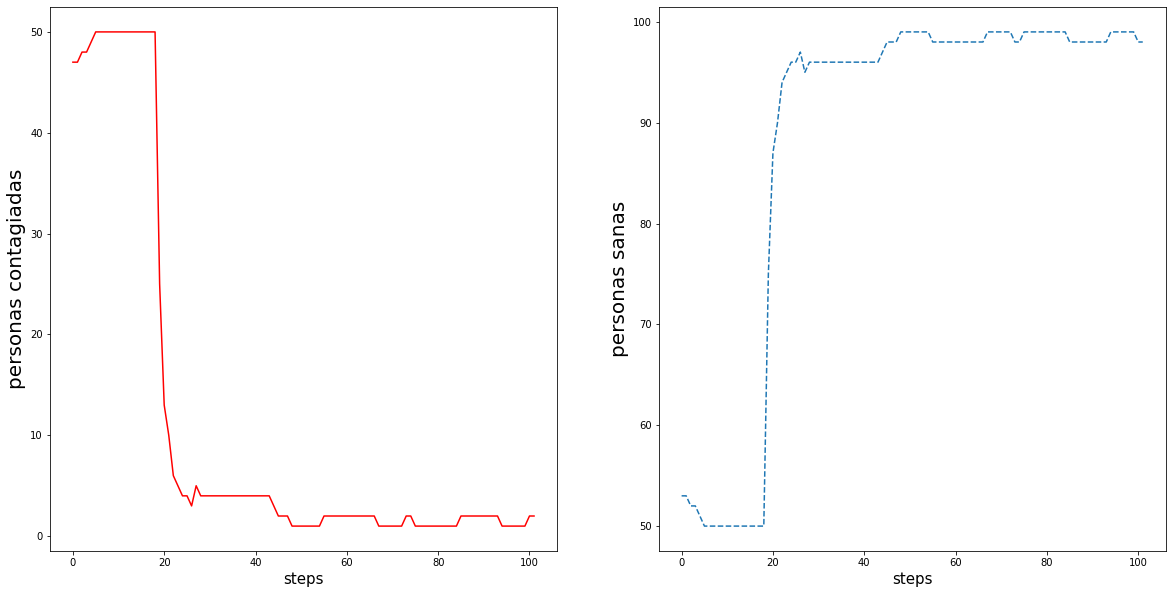

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
contagiados = tablero.get_personas_contagiadas()
no_contagiados = [N_PERSONAS - n for n in contagiados]
index = [i for i in range(len(contagiados))]
#Plot izquierda
axes[0].plot(index, contagiados, color='r')
axes[0].set_xlabel('steps', fontsize=15) #Setea el nombre del eje x
axes[0].set_ylabel('personas contagiadas', fontsize=20)

#Plot derecha
axes[1].plot(index, no_contagiados, linestyle="--")
axes[1].set_xlabel('steps', fontsize=15) #Setea el nombre del eje x
axes[1].set_ylabel('personas sanas', fontsize=20)

plt.show()